<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Dynamic systems: 11. Reactions
## One reactant
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

----
In this notebook, we solve the continuity equation for **one reactant** with terms for:
- advection
- diffusion
- decay

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.animation as animation
import matplotlib.image as mpimg
from IPython.display import HTML
import glob

----
## 2D advection-diffusion-reaction equation

We consider the transport equation for species $A$:
$$\fbox{$
\frac{\partial A}{\partial t}
+ \vec{u} \cdot \nabla A
- \nabla \cdot (D \nabla A)
= f_1 - \lambda_A A
$}$$

The species $A$ might be a **temperature signal**, a **concentration**, or any other quantity.
This quantity can:
- **advect** with velocity $\vec{u}$ (first term on the right-hand side),
- **diffuse** with diffusivity $D$ (second term on the right-hand side),
- **react** according to reaction law $f_1$ (third term on the right-hand side),
- **decay** with decay rate $\lambda_A$ (fourth term on the right-hand side).

We rewrite the transport equation into a finite difference scheme with explicit time
integration, using $\frac{\partial A}{\partial t}=\frac{A(t_{i+1})-A(t_i)}{\Delta t}$:
$$
A(t_{i+1}) = A(t_i) +
\left[
- \vec{u} \cdot \nabla A(t_i)
+ \nabla \cdot (D \nabla A(t_i))
+ f_1 - \lambda_A A(t_i)
\right] \Delta t
$$
In the square brackets, we have the **advection term**, the **diffusion term**,
a **reaction (source-sink) term**, and a **decay term**.

----
## Define functions

### Create mesh
We solve the transport equation for one species $A$ in a 2D domain, with coordinates
$x$ and $y$ [m], defined as 1D arrays with `linspace` from the `numpy` package, 
and then converted to 2D arrays, using `meshgrid` from the `numpy` package.

In [2]:
def create_mesh(xmin=0,xmax=1,ymin=0,ymax=1,nx=11,ny=11):
    x,dx = np.linspace(xmin,xmax,nx,retstep=True)
    y,dy = np.linspace(ymin,ymax,ny,retstep=True)
    #dx = x[1]-x[0]
    #dy = y[1]-y[0]
    X,Y = np.meshgrid(x,y)
    return X,Y,dx,dy

### Initialize field values
As initial conditions, we set the species $A$ to zero, $A(t=0)=0$, except a small circular
area in the center of the modelling domain, where we set $A$ to one.

We also set up the velocity vector by defining 2D arrays for the $x$- and $y$-components
of velocitiy, $Vx$ and $Vy$ [m/s].

In [3]:
def init_fields(X,Y,velx=0,vely=0,nx=11,ny=11):
    # concentration A
    A = np.zeros(nx*ny).reshape(ny,nx)
    xc = (X.min()+X.max()) / 2
    yc = (Y.min()+Y.max()) / 2
    rc = 0.5
    #print(xc,yc,rc)
    for i in range(ny):
        for j in range(nx):
            dist = np.sqrt((X[i,j]-xc)**2 + (Y[i,j]-yc)**2)
            if (dist <= rc):
                A[i,j] = 1.
    # velocity
    Vx = np.ones(nx*ny).reshape(ny,nx)
    Vy = np.ones(nx*ny).reshape(ny,nx)
    Vx = velx*Vx
    Vy = vely*Vy
    Vabs = np.sqrt(Vx**2 + Vy**2)
    return A,Vx,Vy,Vabs

### Plot
Next, we write a function for plotting the fields ...

In [4]:
def plot_fields_vector(X,Y,A,Vx,Vy,Vabs,filename=''):
    xmin = X.min(); xmax = X.max()
    ymin = Y.min(); ymax = Y.max()
    fig, axs = plt.subplots(2,1,figsize=(10,4))
    
    v = np.linspace(0.0, 1.0, 11, endpoint=True)
    #plt.contour(xi, yi, zi, v, linewidths=0.5, colors='k')
    #plt.contourf(xi, yi, zi, v, cmap=plt.cm.jet)
    #x = plt.colorbar(ticks=v)

    axs[0].set_xlim([xmin,xmax])
    axs[0].set_ylim([ymin,ymax])
    CS0=axs[0].contourf(X,Y,A,v, cmap=plt.cm.jet_r)
    cbar = fig.colorbar(CS0,ax=axs[0],orientation="vertical",shrink=0.9)
    cbar.ax.set_ylabel('A [mol/m$^3$]')
    
    axs[1].set_xlim([xmin,xmax])
    axs[1].set_ylim([ymin,ymax])
    CS1=axs[1].quiver(X,Y,Vx/Vabs,Vy/Vabs,Vabs,alpha=0.5,width=0.002,scale=150,pivot="middle")
    axs[1].quiver(X,Y,Vx/Vabs,Vy/Vabs, edgecolor='k', facecolor='None', 
              linewidth=.5,width=0.002,scale=150,pivot="middle")
    cbar = fig.colorbar(CS1,ax=axs[1],orientation="vertical",shrink=0.9)
    cbar.ax.set_ylabel('V [m/s]')
    
    axs[0].set_title('Concentration')
    axs[1].set_title('Velocity')
    axs[0].axis('off')
    axs[1].axis('off')
    if (filename != ''):
        plt.savefig('lab11/'+filename,dpi=300)
        plt.close()

In [5]:
def plot_fields_streamplot(X,Y,A,Vx,Vy,Vabs,filename=''):
    fig, axs = plt.subplots(1,1,figsize=(10,4))
    
    v = np.linspace(0.0, 1.0, 11, endpoint=True)
    #plt.contour(xi, yi, zi, v, linewidths=0.5, colors='k')
    #plt.contourf(xi, yi, zi, v, cmap=plt.cm.jet)
    #x = plt.colorbar(ticks=v)

    axs.set_xlim([xmin,xmax])
    axs.set_ylim([ymin,ymax])
    CS0=axs.contourf(X,Y,A,v,cmap=plt.cm.jet_r)
    cbar = fig.colorbar(CS0,ax=axs,orientation="vertical",shrink=0.9)
    cbar.ax.set_ylabel('A [mol/m$^3$]')
    axs.streamplot(X,Y,Vx/Vabs,Vy/Vabs,color=(0.0,0.0,0.0,0.5),linewidth=1.5)
    axs.set_title('Concentration / streamlines')
    axs.axis('off')
    if (filename != ''):
        plt.savefig('lab11/'+filename,dpi=300)
    plt.close()

Test the functions ...

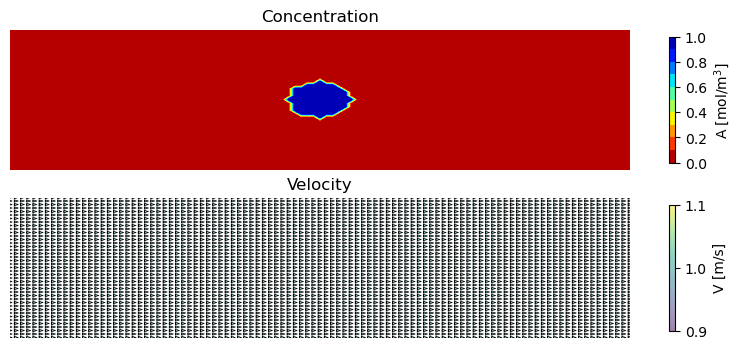

In [6]:
X,Y,dx,dy = create_mesh(xmin=0,xmax=10,ymin=-2,ymax=2,nx=101,ny=41)
A,Vx,Vy,Vabs = init_fields(X,Y,velx=1,vely=0,nx=101,ny=41)
plot_fields_vector(X,Y,A,Vx,Vy,1)

----
## Differential operators as finite-difference operators
From the discussion in the previous notebooks, we have matrix operations for both
**gradient** and **divergence** of a field. We define such matrix operators with two
different approaches ...

The second set of operators, which uses the `roll` function from `numpy`, solves a problem
with periodic boundary conditions (we will see this later ...).

In [7]:
def diffusion(A,dx,dy):
    L = 0.*A
    for i in range(1,A.shape[0]-1):
        for j in range(1,A.shape[1]-1):
            L[i,j] = (A[i+1,j]+A[i-1,j]+A[i,j+1]+A[i,j-1]-4*A[i,j]) / (dx*dy)
    return L

def advection(A,Vx,Vy,dx,dy):
    L = 0.*A
    for i in range(1,A.shape[0]-1):
        for j in range(1,A.shape[1]-1):
            grady = (A[i+1,j]-A[i-1,j]) / (2*dy)
            gradx = (A[i,j+1]-A[i,j-1]) / (2*dx)
            L[i,j] = Vx[i,j]*gradx + Vy[i,j]*grady
    return L

In [8]:
def discrete_laplacian(M,dx,dy):
    """L = nabla^2 M"""
    L = -4*M
    L += np.roll(M, (0,-1), (0,1)) # right neighbor
    L += np.roll(M, (0,+1), (0,1)) # left neighbor
    L += np.roll(M, (-1,0), (0,1)) # top neighbor
    L += np.roll(M, (+1,0), (0,1)) # bottom neighbor
    L = L / (dx*dy)
    return L

def discrete_divergence(M,Vx,Vy,dx,dy):
    """L = V*nabla M"""
    gradx  = np.roll(M, (0,-1), (0,1)) # right neighbor
    gradx -= np.roll(M, (0,+1), (0,1)) # left neighbor
    gradx  = gradx / (2*dx)
    grady  = np.roll(M, (-1,0), (0,1)) # top neighbor
    grady -= np.roll(M, (+1,0), (0,1)) # bottom neighbor
    grady  = grady / (2*dy)
    L = Vx*gradx + Vy*grady
    return L

----
## Function for solving differential equation
In this final function, we solve the 2D transport equation for one species ...
$$
A(t_{i+1}) = A(t_i) +
\left[
- \vec{u} \cdot \nabla A(t_i)
+ \nabla \cdot (D \nabla A(t_i))
+ f_1 - \lambda_A A(t_i)
\right] \Delta t
$$

In [9]:
def update_fields(A,Vx,Vy,DA,lambA,dt,dx,dy):
    nx = A.shape[0]
    ny = A.shape[1]
    # diffusion
    #laplacian = diffusion(A,dx,dy)
    #gradient  = advection(A,Vx,Vy,dx,dy)
    laplacian = discrete_laplacian(A,dx,dy)
    gradient  = discrete_divergence(A,Vx,Vy,dx,dy)
    reaction  = lambA*A

    # Now apply the update formula
    diff_A = (-gradient + DA*laplacian - reaction) * dt
    #diff_B = (DB*LB + A*B**2 - (k+f)*B) * delta_t

    A += diff_A
    #B += diff_B
    #print(A.min(),A.max())

    return A

---- 
## Examples
Now we need to apply our 2D transport equation model for one species, and therefore we design 
different experiments...

### Diffusion only

In [10]:
xmin  = 0. 
xmax  = 10.
ymin  = -2. 
ymax  = +2.
nx    = 101
ny    = 41
DA    = 5e-3
lambA = 0.0
velx  = 0.0
vely  = 0.
tmin  = 0.
tmax  = 15.
dt    = 0.005
name  = 'ONE-diff-'

X,Y,dx,dy = create_mesh(xmin,xmax,ymin,ymax,nx,ny)
A,Vx,Vy,Vabs = init_fields(X,Y,velx,vely,nx,ny)
#plot_fields(X,Y,A,Vx,Vy,Vabs,name+f"{0:04}.png")
plot_fields_streamplot(X,Y,A,Vx,Vy,Vabs,name+f"{0:04}.png")
time = 0.
tsave = 0.
twrite = 1.
iwrite = 1
while (time < tmax):
    #print(time)
    tsave = tsave + dt
    time = time + dt
    A = update_fields(A,Vx,Vy,DA,lambA,dt,dx,dy)
    if (tsave >= twrite):
        tsave = 0.
        filename = f"ONE-{iwrite:04}.png"
        print(time,tsave,twrite,A.min(),A.max(),np.sum(A))
        #plot_fields(X,Y,A,Vx,Vy,Vabs,name+f"{iwrite:04}.png")
        plot_fields_streamplot(X,Y,A,Vx,Vy,Vabs,name+f"{iwrite:04}.png")
        iwrite = iwrite + 1

/var/folders/g1/lkn34rdd3158l1w_kz2l0dt80000gn/T/ipykernel_1092/1795591650.py:14: RuntimeWarning: invalid value encountered in divide
  axs.streamplot(X,Y,Vx/Vabs,Vy/Vabs,color=(0.0,0.0,0.0,0.5),linewidth=1.5)


1.0000000000000007 0.0 1.0 9.35875427525412e-99 0.9997181219674026 76.0
1.9999999999999793 0.0 1.0 1.0966224724720154e-77 0.9942173487644977 76.0
2.9999999999999583 0.0 1.0 2.049493250904425e-66 0.9761575525029975 76.0
3.999999999999937 0.0 1.0 8.171254166999776e-59 0.9455680598824728 76.0
4.999999999999916 0.0 1.0 3.756561747652975e-53 0.9068829387127225 76.0
5.999999999999894 0.0 1.0 1.0944820514903642e-48 0.8645419732731766 76.0
6.999999999999873 0.0 1.0 4.908308778327705e-45 0.821620569297623 76.0
7.999999999999852 0.0 1.0 5.7062750651115144e-42 0.7799212128227823 76.0
9.000000000000007 0.0 1.0 2.397713651768973e-39 0.7403739077935223 76.0
10.000000000000163 0.0 1.0 4.559358494316452e-37 0.7033781669392969 76.0
11.00000000000032 0.0 1.0 4.600187593031785e-35 0.6690316372028108 75.99999999999999
12.000000000000476 0.0 1.0 2.76750507581802e-33 0.6372695220156391 75.99999999999997
13.000000000000632 0.0 1.0 1.0841376723693868e-31 0.6079459514168171 76.0
14.000000000000789 0.0 1.0 2.96

Compile png files created to movie sequence and show in browser ...

In [11]:
# list all png files in directory
imageList = sorted(glob.glob("lab11/ONE-diff-0*.png"))
#print(imageList)

# define figure handle and empty array for list of figures    
fig = plt.figure(figsize=(15,5))
ims = []
# loop over all figures, load them into image and apprend to array ims
for i in range(len(imageList)):
    image = mpimg.imread(imageList[i])
    img=plt.imshow(image)
    plt.axis('off')
    #print(i,getImageFromList(i))
    ims.append([img])
print('assembled images to list')
# create an animation object
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat=False)
print('created animation sequence')
plt.close()
print('opening in web browser ...')
HTML(ani.to_jshtml())

assembled images to list
created animation sequence
opening in web browser ...


In [ ]:
#ani.save('lab11/ONE-diff.mp4',fps=2,extra_args=['-vcodec','libx264'])

### Diffusion and advection

In [12]:
xmin  = 0. 
xmax  = 10.
ymin  = -2. 
ymax  = +2.
nx    = 101
ny    = 41
DA    = 5e-3
lambA = 0.0
velx  = 0.1
vely  = 0.
tmin  = 0.
tmax  = 25.
dt    = 0.005
name  = 'ONE-diff-adv-'

X,Y,dx,dy = create_mesh(xmin,xmax,ymin,ymax,nx,ny)
A,Vx,Vy,Vabs = init_fields(X,Y,velx,vely,nx,ny)
plot_fields_streamplot(X,Y,A,Vx,Vy,Vabs,name+f"{0:04}.png")
time = 0.
tsave = 0.
twrite = 1.
iwrite = 1
while (time < tmax):
    #print(time)
    tsave = tsave + dt
    time = time + dt
    A = update_fields(A,Vx,Vy,DA,lambA,dt,dx,dy)
    if (tsave >= twrite):
        tsave = 0.
        filename = f"ONE-{iwrite:04}.png"
        print(time,tsave,twrite,A.min(),A.max(),np.sum(A))
        plot_fields_streamplot(X,Y,A,Vx,Vy,Vabs,name+f"{iwrite:04}.png")
        iwrite = iwrite + 1

1.0000000000000007 0.0 1.0 -1.304512053934561e-17 0.9997756289160727 76.0
1.9999999999999793 0.0 1.0 -6.054184931159124e-18 0.9945577413738974 75.99999999999999
2.9999999999999583 0.0 1.0 -2.9793875699902502e-18 0.9775772044117814 76.0
3.999999999999937 0.0 1.0 -1.2468324983584198e-18 0.9496982521729744 76.0
4.999999999999916 0.0 1.0 -5.220433460518606e-19 0.91118691275772 76.0
5.999999999999894 0.0 1.0 -2.111483730916429e-19 0.8678123722622803 76.0
6.999999999999873 0.0 1.0 -8.395790573193676e-20 0.8236265808053845 75.99999999999999
7.999999999999852 0.0 1.0 -3.327145416823932e-20 0.7808123696435395 76.0
9.000000000000007 0.0 1.0 -1.3001955740443919e-20 0.7403938870515708 75.99999999999999
10.000000000000163 0.0 1.0 -5.0377284538853585e-21 0.7027587326669283 76.0
11.00000000000032 0.0 1.0 -1.946058196407164e-21 0.66796265949891 75.99999999999999
12.000000000000476 0.0 1.0 -7.485653672264005e-22 0.6358969679014582 75.99999999999999
13.000000000000632 0.0 1.0 -2.8468247970666256e-22 0.6

In [13]:
# list all png files in directory
imageList = sorted(glob.glob("lab11/ONE-diff-adv-0*.png"))
#print(imageList)

# define figure handle and empty array for list of figures    
fig = plt.figure(figsize=(15,5))
ims = []
# loop over all figures, load them into image and apprend to array ims
for i in range(len(imageList)):
    image = mpimg.imread(imageList[i])
    img=plt.imshow(image)
    #print(i,getImageFromList(i))
    ims.append([img])
print('assembled images to list')
# create an animation object
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat=False)
print('created animation sequence')
plt.close()
print('opening in web browser ...')
HTML(ani.to_jshtml())

assembled images to list
created animation sequence
opening in web browser ...


### Diffusion, advection, and decay

In [ ]:
xmin  = 0. 
xmax  = 10.
ymin  = -2. 
ymax  = +2.
nx    = 101
ny    = 41
DA    = 5e-3
lambA = 0.05
velx  = 0.1
vely  = 0.05
tmin  = 0.
tmax  = 25.
dt    = 0.005
name  = 'ONE-diff-adv-decay-'

X,Y,dx,dy = create_mesh(xmin,xmax,ymin,ymax,nx,ny)
A,Vx,Vy,Vabs = init_fields(X,Y,velx,vely,nx,ny)
plot_fields_streamplot(X,Y,A,Vx,Vy,Vabs,name+f"{0:04}.png")
time = 0.
tsave = 0.
twrite = 1.
iwrite = 1
while (time < tmax):
    #print(time)
    tsave = tsave + dt
    time = time + dt
    A = update_fields(A,Vx,Vy,DA,lambA,dt,dx,dy)
    if (tsave >= twrite):
        tsave = 0.
        filename = f"ONE-{iwrite:04}.png"
        print(time,tsave,twrite,A.min(),A.max(),np.sum(A))
        plot_fields_streamplot(X,Y,A,Vx,Vy,Vabs,name+f"{iwrite:04}.png")
        iwrite = iwrite + 1

In [ ]:
# list all png files in directory
imageList = sorted(glob.glob("lab11/ONE-diff-adv-decay-0*.png"))
#print(imageList)

# define figure handle and empty array for list of figures    
fig = plt.figure(figsize=(15,5))
ims = []
# loop over all figures, load them into image and apprend to array ims
for i in range(len(imageList)):
    image = mpimg.imread(imageList[i])
    img=plt.imshow(image)
    #print(i,getImageFromList(i))
    ims.append([img])
print('assembled images to list')
# create an animation object
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat=False)
print('created animation sequence')
plt.close()
print('opening in web browser ...')
HTML(ani.to_jshtml())

... done